In [1]:
%reset -f

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import data_process, data_functions, data_generator, keras_model
from path import path_dict, col_seq_cc, col_seq_can

In [6]:
%config Completer.use_jedi = False

In [7]:
pmpm = pd.read_pickle("../temp/pmpm_ccm.p")

In [8]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_IP  ALLOW_ER  \
0  2612620  201510        M               75          0       0.0       0.0   
1  2613447  201510        M               75       2159       0.0       0.0   
2  2613818  201510        M               75        176       0.0       0.0   
3  2740429  201510        M               61          0       0.0       0.0   
4  2736648  201510        M               61        213       0.0       0.0   

   CC_HYPOTHYROID  CC_AMI  CC_ALZHEIMER  ...  CC_HEPATITIS_A  \
0               0       0             0  ...               0   
1               0       0             0  ...               0   
2               0       0             0  ...               0   
3               0       0             0  ...               0   
4               0       0             0  ...               0   

   CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       0                     0   
4                     0                       0                     0   

   CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  \
0                       0                           0               0   
1                       0                           0               0   
2                       0                           0               0   
3                       0                           0               0   
4                       0                           0               0   

   CC_HEPATITIS_E  CC_DX_CNT  CC_DISAB_DX_CNT  
0               0          0                0  
1               0          7                0  
2               0          7                0  
3               0          1                0  
4               0          1                0  

[5 rows x 76 columns]

In [9]:
pmpm.MYR.min(), pmpm.MYR.max()

(201510, 202006)

In [10]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [15]:
def get_training_date_range(pmpm, start, end):
    date_list = pmpm.MYR.sort_values().unique().tolist()
    start_index = date_list.index(start)
    end_index = date_list.index(end)
    return date_list[start_index:end_index+1]

In [16]:
def return_stacked_training_data(pmpm, train_start, train_end, offset):
    
    training_period = get_training_date_range(pmpm.copy(), train_start, train_end)
    print(f"Training Period {training_period}")
    
    feature_start = [i for (i, _) in enumerate(training_period) if i%offset==0]
    feature_end   = [i+(offset-1) for i in feature_start]
    label_start   = [feature_start[i] for (i,_) in enumerate(feature_start) if i>0]
    label_end     = [feature_end[i] for (i,_) in enumerate(feature_end) if i>0]

    feature_start = feature_start[:-1]
    feature_end   = feature_end  [:-1]

    print(f"Feature Start Month Indices: {feature_start}")
    print(f"Feature End Month Indices: {feature_end}")
    print(f"Label Start Month Indices: {label_start}")
    print(f"Label End Month Indices: {label_end}")
    
    for i, val in enumerate(feature_start):
        if i==0:
            training_features, sample_weight = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_cc)
            training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_cc)
            training_features, training_labels = data_generator.make_intersection(training_features, training_labels)
            training_features, sample_weight = data_generator.make_intersection(training_features, sample_weight)
            
            training_features = training_features.set_index('PERS_ID')
            training_labels = training_labels.set_index('PERS_ID')
            
            print(f"{training_features.shape} samples added with {training_labels.shape} labels and {sample_weight.shape} weights")

        else:
            new_training_features, new_sample_weights = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_cc)
            new_training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_cc)
            
            new_training_features, new_training_labels = data_generator.make_intersection(new_training_features, new_training_labels)
            new_training_features, new_sample_weights = data_generator.make_intersection(new_training_features, new_sample_weights)
            
            new_training_features = new_training_features.set_index('PERS_ID')
            new_training_labels = new_training_labels.set_index('PERS_ID')

            print(f"{new_training_features.shape} samples added with {new_training_labels.shape} labels and {new_sample_weights.shape} weights")

            training_features = training_features.append(new_training_features, ignore_index=True)
            training_labels   = training_labels.append(new_training_labels, ignore_index=True)
            sample_weight     = sample_weight.append(new_sample_weights, ignore_index=True)

        print(f"Current Trainset size {training_features.shape}")
        
    return training_features, training_labels, sample_weight

In [17]:
%%time
train_data, training_labels, sample_weight = return_stacked_training_data(pmpm.copy(), 201601, 201912, offset=12)

Training Period [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912]
Feature Start Month Indices: [0, 12, 24]
Feature End Month Indices: [11, 23, 35]
Label Start Month Indices: [12, 24, 36]
Label End Month Indices: [23, 35, 47]
(313052, 74) samples added with (313052, 74) labels and (313052, 3) weights
Current Trainset size (313052, 74)
(310540, 74) samples added with (310540, 74) labels and (310540, 3) weights
Current Trainset size (623592, 74)
(303449, 74) samples added with (303449, 74) labels and (303449, 3) weights
Current Trainset size (927041, 74)
CPU times: user 3min 25s, sys: 1min 32s, total: 4min 57s
Wall time: 4min 58s


In [18]:
train_data = train_data.dropna()

In [19]:
train_data

AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  \
0             38.916667       0.0   1.020536  0.000000       0.0      0.0   
1             36.416667       1.0   0.414151  0.000000       0.0      0.0   
2            102.250000       1.0   5.711018  0.488394       0.0      0.0   
3            101.916667       0.0   5.868299  2.164558       0.0      0.0   
4            101.666667       0.0   3.933242  0.000000       0.0      0.0   
...                 ...       ...        ...       ...       ...      ...   
927036        29.000000       0.0   4.570259  0.000000       0.0      0.0   
927037         0.000000       1.0   4.801630  0.484332       0.0      0.0   
927038         5.000000       0.0   1.105907  0.000000       0.0      0.0   
927039         5.166667       1.0   1.938929  0.000000       0.0      0.0   
927040        27.166667       0.0   4.754901  0.000000       0.0      0.0   

        CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0                0.0           0.000000     0.0        0.0  ...   
1                0.0           0.000000     0.0        0.0  ...   
2                0.0           0.000000     0.0        0.0  ...   
3                0.0           0.416667     0.0        0.0  ...   
4                0.0           0.000000     0.0        0.0  ...   
...              ...                ...     ...        ...  ...   
927036           0.0           0.000000     0.0        0.0  ...   
927037           0.0           0.000000     0.0        0.0  ...   
927038           0.0           0.000000     0.0        0.0  ...   
927039           0.0           0.000000     0.0        0.0  ...   
927040           0.0           0.000000     0.0        0.0  ...   

        CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                      0.0      0.0               0.0                     0.0   
1                      0.0      0.0               0.0                     0.0   
2                      0.0      0.0               0.0                     0.0   
3                      0.0      0.0               0.0                     0.0   
4                      0.0      0.0               0.0                     0.0   
...                    ...      ...               ...                     ...   
927036                 0.0      0.0               0.0                     0.0   
927037                 0.0      0.0               0.0                     0.0   
927038                 0.0      0.0               0.0                     0.0   
927039                 0.0      0.0               0.0                     0.0   
927040                 0.0      0.0               0.0                     0.0   

        CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  \
0                  0.0              0.0        0.0         0.0   
1                  0.0              0.0        0.0         0.0   
2                  0.0              0.0        0.0         0.0   
3                  0.0              0.0        0.0         0.0   
4                  0.0              0.0        0.0         0.0   
...                ...              ...        ...         ...   
927036             0.0              0.0        0.0         0.0   
927037             0.0              0.0        0.0         0.0   
927038             0.0              0.0        0.0         0.0   
927039             0.0              0.0        0.0         0.0   
927040             0.0              0.0        0.0         0.0   

        CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                      0.0               0.0  
1                      0.0               0.0  
2                      0.0               0.0  
3                      0.0               0.0  
4                      0.0               0.0  
...                    ...               ...  
927036                 0.0               0.0  
927037                 0.0               0.0  
927038                 0.0               0.0  
927039                 0.0               0

In [20]:
training_labels = training_labels.dropna()

In [21]:
training_labels

AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  \
0             39.916667       0.0   0.000000  0.000000       0.0      0.0   
1             37.416667       1.0   0.000000  0.000000       0.0      0.0   
2            103.250000       1.0   5.318053  0.502336       0.0      0.0   
3            102.900000       0.0   6.403244  2.588725       0.0      0.0   
4            102.666667       0.0   4.828851  0.927983       0.0      0.0   
...                 ...       ...        ...       ...       ...      ...   
927036        30.000000       0.0   4.723084  0.000000       0.0      0.0   
927037         1.000000       1.0   3.399479  1.357104       0.0      0.0   
927038         6.000000       0.0   2.069508  0.000000       0.0      0.0   
927039         6.166667       1.0   1.683187  0.000000       0.0      0.0   
927040        28.166667       0.0   3.824449  0.000000       0.0      0.0   

        CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0                0.0                0.0     0.0        0.0  ...   
1                0.0                0.0     0.0        0.0  ...   
2                0.0                0.0     0.0        0.0  ...   
3                0.0                1.0     0.0        0.0  ...   
4                0.0                0.0     0.0        0.0  ...   
...              ...                ...     ...        ...  ...   
927036           0.0                0.0     0.0        0.0  ...   
927037           0.0                0.0     0.0        0.0  ...   
927038           0.0                0.0     0.0        0.0  ...   
927039           0.0                0.0     0.0        0.0  ...   
927040           0.0                0.0     0.0        0.0  ...   

        CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                      0.0      0.0               0.0                     0.0   
1                      0.0      0.0               0.0                     0.0   
2                      0.0      0.0               0.0                     0.0   
3                      0.0      0.0               0.0                     0.0   
4                      0.0      0.0               0.0                     0.0   
...                    ...      ...               ...                     ...   
927036                 0.0      0.0               0.0                     0.0   
927037                 0.0      0.0               0.0                     0.0   
927038                 0.0      0.0               0.0                     0.0   
927039                 0.0      0.0               0.0                     0.0   
927040                 0.0      0.0               0.0                     0.0   

        CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  \
0                  0.0              0.0        0.0         0.0   
1                  0.0              0.0        0.0         0.0   
2                  0.0              0.0        0.0         0.0   
3                  0.5              0.0        0.0         0.0   
4                  0.0              0.0        0.0         0.0   
...                ...              ...        ...         ...   
927036             0.0              0.0        0.0         0.0   
927037             0.0              0.0        0.0         0.0   
927038             0.0              0.0        0.0         0.0   
927039             0.0              0.0        0.0         0.0   
927040             0.0              0.0        0.0         0.0   

        CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                      0.0               0.0  
1                      0.0               0.0  
2                      0.0               0.0  
3                      0.0               0.0  
4                      0.0               0.0  
...                    ...               ...  
927036                 0.0               0.0  
927037                 0.0               0.0  
927038                 0.0               0.0  
927039                 0.0               0

## Sample weight calculation

In [22]:
sample_weight

PERS_ID   0    weight
0       2561295  12  1.000000
1       2561296  12  1.000000
2       2562628  12  1.000000
3       2562714  12  1.000000
4       2562798  12  1.000000
...         ...  ..       ...
927036  5022999  12  1.000000
927037  5029148  10  0.833333
927038  5032881  12  1.000000
927039  5038017  12  1.000000
927040  5038909  12  1.000000

[927041 rows x 3 columns]

In [23]:
sample_weight.weight.values

array([1., 1., 1., ..., 1., 1., 1.])

## Training

In [24]:
baseline_model = keras_model.make_model_6(input_shape=train_data.shape[1])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 74)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [25]:
%%time
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_data.values, training_labels.values, epochs=num_epochs, validation_split=0.1, 
                                      batch_size=128, verbose=1, sample_weight=sample_weight.weight.values)

Train on 834336 samples, validate on 92705 samples
Epoch 1/20
834336/834336 [==============================] - 17s 21us/step - loss: 0.9393 - val_loss: 0.4057
Epoch 2/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.5152 - val_loss: 0.3666
Epoch 3/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3992 - val_loss: 0.3820
Epoch 4/20
834336/834336 [==============================] - 17s 21us/step - loss: 0.3527 - val_loss: 0.3876
Epoch 5/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3523 - val_loss: 0.3886
Epoch 6/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3522 - val_loss: 0.3872
Epoch 7/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3519 - val_loss: 0.3870
Epoch 8/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3518 - val_loss: 0.3880
Epoch 9/20
834336/834336 [==============================] - 17s 20us/step - loss: 0.3

In [26]:
baseline_history.history.keys()

dict_keys(['val_loss', 'loss'])

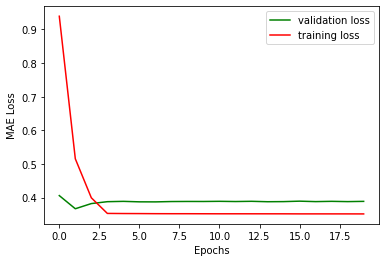

In [27]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history.get('val_loss'), color="green", label="validation loss")
plt.plot(baseline_history.history.get('loss'), color='red', label="training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('MAE Loss')
plt.show()

In [28]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [29]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

In [30]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m6_CCM_stacked')
latent_model.save('../temp/TF_Latent_Model_m6_CCM_stacked')

In [31]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6_CCM_stacked',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m6_CCM_stacked',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6_CCM_stacked',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m6_CCM_stacked',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})